<a href="https://colab.research.google.com/github/Baroka-wp/dive_ML/blob/master/creation_de_donnees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import numpy  as np
import os
import glob 
import re
import matplotlib.pyplot as plt

from PIL import Image
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras import optimizers
from tensorflow.keras.optimizers import Adam
import albumentations as A

import cv2
%matplotlib inline

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [3]:
path = '/content/drive/MyDrive/training' 
flist = os.listdir(path)

In [4]:
flist

['cat_102.jpg',
 'cat_103.jpg',
 'dog_107.jpg',
 'cat_105.jpg',
 'dog_108.jpg',
 'dog_111.jpg',
 'cat_106.jpg',
 'dog_120.jpg',
 'dog_109.jpg',
 '.ipynb_checkpoints',
 'cat_104.jpg']

## [Problème 1] Apprentissage de la classification avec un ensemble de données auto-fabriqué


In [5]:
flist_ignore = [name for name in os.listdir(path) if not name.startswith('.')]
flist_ignore

['cat_102.jpg',
 'cat_103.jpg',
 'dog_107.jpg',
 'cat_105.jpg',
 'dog_108.jpg',
 'dog_111.jpg',
 'cat_106.jpg',
 'dog_120.jpg',
 'dog_109.jpg',
 'cat_104.jpg']

In [6]:
img_list = glob.glob(path + '/*' + ".jpg")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 2
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [8]:
image_generator = ImageDataGenerator(rescale=1./255)


In [49]:
!ls /content/drive/MyDrive/training

cat  dog


In [30]:
gen_train = image_generator.flow_from_directory(batch_size=batch_size,
                                          directory="drive/MyDrive/training/",
                                          shuffle=True,
                                          target_size=(IMG_HEIGHT, IMG_WIDTH),
                                          class_mode='binary')

Found 10 images belonging to 2 classes.


In [31]:
import matplotlib.pyplot as plt


In [34]:
train_data, labels = next(gen_train)


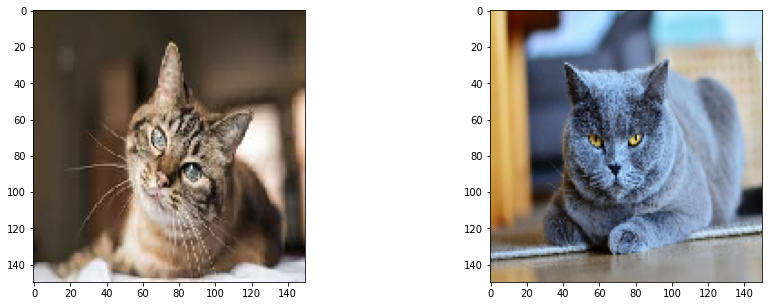

In [35]:
plt.figure(figsize=(15,5))
for i in range(len(train_data)):
    plt.subplot(1, 2, i+1)
    plt.imshow(train_data[i])

In [37]:
model = Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [43]:
model.compile(loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [44]:
model.fit_generator(generator=gen_train, epochs=epochs)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


5/5 [==============================] - 2s 168ms/step - loss: 3.0444 - accuracy: 0.3000
Epoch 2/15
5/5 [==============================] - 1s 163ms/step - loss: 0.8393 - accuracy: 0.5000
Epoch 3/15
5/5 [==============================] - 1s 180ms/step - loss: 0.6736 - accuracy: 0.6000
Epoch 4/15
5/5 [==============================] - 1s 166ms/step - loss: 0.6474 - accuracy: 0.7000
Epoch 5/15
5/5 [==============================] - 1s 164ms/step - loss: 0.5448 - accuracy: 1.0000
Epoch 6/15
5/5 [==============================] - 1s 164ms/step - loss: 0.4236 - accuracy: 1.0000
Epoch 7/15
5/5 [==============================] - 1s 176ms/step - loss: 0.2622 - accuracy: 1.0000
Epoch 8/15
5/5 [==============================] - 1s 164ms/step - loss: 0.1067 - accuracy: 1.0000
Epoch 9/15
5/5 [==============================] - 1s 165ms/step - loss: 0.0620 - accuracy: 1.0000
Epoch 10/15
5/5 [==============================] - 1s 161ms/step - loss: 0.0095 - accuracy: 1.0000
Epoch 11/15
5/5 [=============

## [Problem 3] Preparation of object detection dataset


In [46]:
def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 2, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 2,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(7, 7))
    plt.imshow(img)

In [47]:
def download_image(url):
    data = open(url,"rb").read()
    data = np.frombuffer(data, np.uint8)
    image = cv2.imdecode(data, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

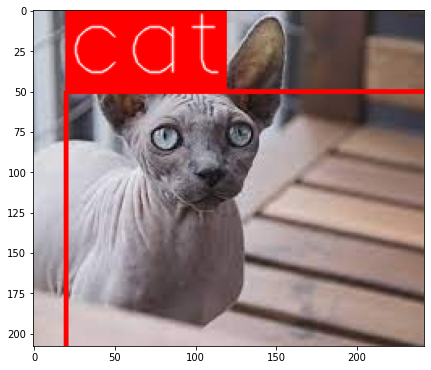

In [52]:
image = download_image('drive/MyDrive/training/cat/cat_105.jpg')
image = np.array(image)

annotations = {'image': image, 'bboxes': [[20,50,1000,1000]], 'category_id': [0]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)

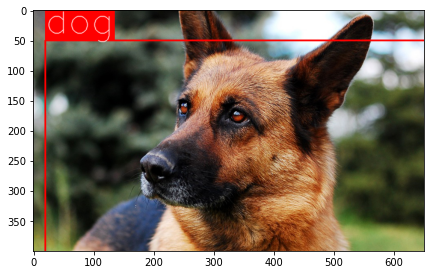

In [55]:
image = download_image('drive/MyDrive/training/dog/dog_111.jpg')
image = np.array(image)

annotations = {'image': image, 'bboxes': [[20,50,700,700]], 'category_id': [1]}
category_id_to_name = {0: 'cat', 1: 'dog'}
img = visualize(annotations, category_id_to_name)

## [Problème 4] Expansion des données pour l'ensemble de données de détection d'objets.


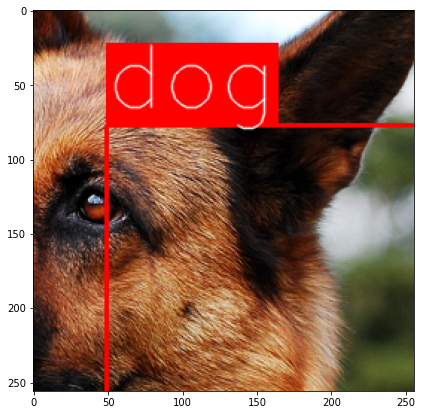

In [57]:
aug = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)

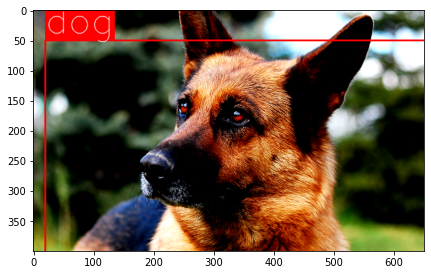

In [58]:
aug = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=1, contrast_limit=1, p=1.0),
])
augmented = aug(**annotations)
visualize(augmented, category_id_to_name)